In [1]:

import gpflow

In [2]:
import math
import random
import decimal
import numpy.random as nrand
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)
plt = matplotlib.pyplot

In [3]:
def ou_values(a,b,dt,sigma,time):
    #This method returns the rate levels of a mean-reverting ornstein uhlenbeck process.
    x = np.zeros(len(time))
    for i in range(0, len(time)-1):
        x[i+1]=x[i]+a*(b-x[i])*dt+math.sqrt(dt)*sigma*np.random.normal(0,1)
    return x

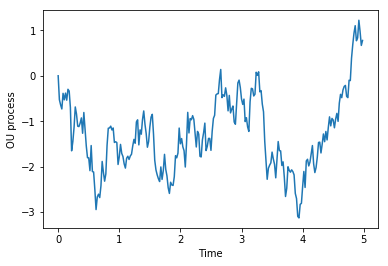

In [4]:
dt=0.02
time=np.arange(0,5,dt)# time
sigma=2
a=1# the coefficient in front, the rate
b=0# the mean
#Simulation of an OU process
x=ou_values(a,b,dt,sigma,time)# the first one is zero because param_all_r0 starts at 0
t=time# time vector
plt.plot(t,x)
plt.xlabel('Time')
plt.ylabel('OU process')
plt.show()

In [5]:
len(time)


250

In [6]:
t_column=t.reshape(-1,1)
x_column=x.reshape(-1,1)

In [7]:
with gpflow.defer_build():
    k=gpflow.kernels.Matern12(1, lengthscales=0.3)
    meanf = gpflow.mean_functions.Linear(1.0, 0.0)

    m = gpflow.models.GPR(t_column,x_column, k, meanf)
    m.likelihood.variance = 0.1# get this to be bigger
    

In [8]:
#m.clear()
m.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m.compile()
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.3
GPR/kern/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,"Ga(1.0,1.0)",+ve,True,(),True,0.1
GPR/mean_function/A,Parameter,"N(0.0,10.0)",(none),True,"(1, 1)",True,[[1.0]]
GPR/mean_function/b,Parameter,"N(0.0,10.0)",(none),True,(),True,0.0


In [9]:
k1=gpflow.kernels.Matern12(1, lengthscales=5,variance=5)
meanf1 = gpflow.mean_functions.Linear(5.0, 10.0)
m1 = gpflow.models.GPR(t_column,x_column, k1, meanf1)
m1.likelihood.variance = 1# get this to be bigger

In [10]:
#m1.clear()
m1.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m1.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m1.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m1.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m1.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m1.compile()
m1.as_pandas_table()


GPflowError: Parameter "GPR/kern/lengthscales" has already been compiled.

In [ ]:
k2=gpflow.kernels.Matern12(1, lengthscales=20,variance=10)
meanf2 = gpflow.mean_functions.Linear(10.0, 5.0)
m2 = gpflow.models.GPR(t_column,x_column, k2, meanf2)
m2.likelihood.variance = 2# get this to be bigger

In [ ]:
#m2.clear()
m2.kern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m2.kern.variance.prior = gpflow.priors.Gamma(1., 1.)
m2.likelihood.variance.prior = gpflow.priors.Gamma(1., 1.)
m2.mean_function.A.prior = gpflow.priors.Gaussian(0., 10.)
m2.mean_function.b.prior = gpflow.priors.Gaussian(0., 10.)
m2.compile()
m2.as_pandas_table()

In [11]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=100, epsilon=0.003,logprobs=True,lmin=18, lmax=20, burn=100,thin=10)
print('acceptance rate: ', len(set(samples.logprobs))/len(samples.logprobs))
samples = samples.drop('logprobs', axis=1)

acceptance rate:  0.65


In [12]:
#?sampler.sample

Text(0, 0.5, 'parameter value')

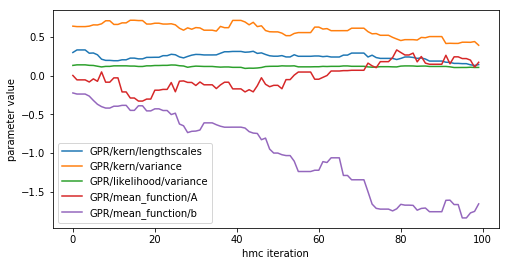

In [13]:
plt.figure(figsize=(8,4))
for i, col in samples.iteritems():
    plt.plot(col, label=col.name)
plt.legend(loc=0)
plt.xlabel('hmc iteration')
plt.ylabel('parameter value')

Text(0, 0.5, 'signal_variance')

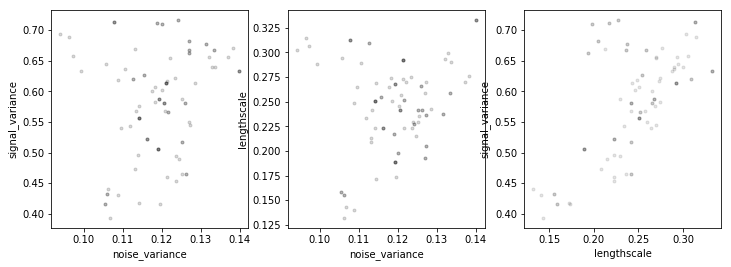

In [14]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(samples['GPR/likelihood/variance'],
            samples['GPR/kern/lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(samples['GPR/kern/lengthscales'],
            samples['GPR/kern/variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

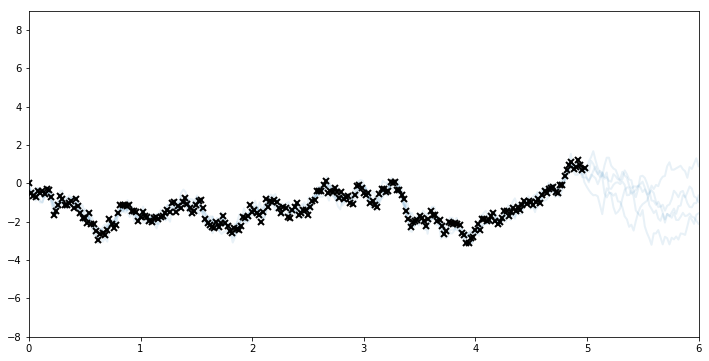

In [15]:
#plot the function posterior
xx = np.linspace(0, 6, 300)[:,None]
plt.figure(figsize=(12, 6))
for i, s in samples.iloc[::20].iterrows():
    f = m.predict_f_samples(xx, 1, initialize=False, feed_dict=m.sample_feed_dict(s))
    plt.plot(xx, f[0,:,:], 'C0', lw=2, alpha=0.1)
    
plt.plot(t, x, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(-8, 9)